<a href="https://colab.research.google.com/github/qkrwjdduf159/dadaiksunTeamProject/blob/main/ipynb/%EB%B0%95%EC%A0%95%EC%97%B4/Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
class modeling:
  !pip install catboost
  # train과 test로 나누기
  def train_test_split(data = None):
    train = data[data['date'] <= 201712]
    test = data[data['date'] > 201712]

    X_train, y_train = train.drop('target', axis = 1), train['target']
    X_test, y_test = test.drop('target', axis = 1), test['target']

    return X_train, X_test, y_train, y_test

  # linear regression 돌리기
  def lr():
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    
    return model

  # xgboost 돌리기
  def xgb():
    from xgboost import XGBRegressor
    model = XGBRegressor(random_state = 42,tree_method = 'gpu_hist')

    return model

  # lightgbm
  def lgb():
    from lightgbm import LGBMRegressor
    model = LGBMRegressor(random_state = 42)

    return model

  # catboost
  def cat():
    from catboost import CatBoostRegressor
    model = CatBoostRegressor(random_state = 42,task_type = 'GPU')

    return model

  # ridge
  def ridge():
    from sklearn.linear_model import Ridge
    model = Ridge(random_state = 42)
    
    return model
  
  # lasso
  def lasso():
    from sklearn.linear_model import Lasso
    model = Lasso()

    return model

  # adaboost
  def ada():
    from sklearn.ensemble import AdaBoostRegressor
    model = AdaBoostRegressor(random_state = 42)

    return model

  # randomforest
  def rfg():
    from sklearn.ensemble import RandomForestRegressor
    model = RandomForestRegressor(random_state = 42)

    return model

  def rmse(y_test, y_pred):
    from sklearn.metrics import mean_squared_error
    RMSE = mean_squared_error(y_test, y_pred)**0.5

    return RMSE

# 모델 전부 한번씩 돌려보기
class class_all_model:
  # 각 모델을 돌리기 위해서 dict로 쌓아준다.
  def models():
    models = {'lr':modeling.lr(), 'lgb':modeling.lgb(), 'xgb':modeling.xgb(), 'lasso':modeling.lasso(),'ridge':modeling.ridge(),'cat':modeling.cat(),'ada':modeling.ada(), 'rfg':modeling.rfg()}
    return models
  
  # 모델을 하나씩 돌려서 keys = 모델명, value = 모델의 rmse를 쌓아준다.
  def run(data = None):
    models = class_all_model.models()
    final_models = {}
    model_score = {}
    X_train, X_test, y_train, y_test = modeling.train_test_split(data = data)
    for i, j in models.items():
      model = j
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)

      final_models[i] = modeling.rmse(y_test, y_pred)
      model_score[i] = model.score(X_test, y_test)
    return final_models, model_score

# stacking ensemble
class class_stack:
  def stack(data = None):
    !pip install vecstack
    from sklearn.metrics import mean_squared_error
    from vecstack import stacking
    X_train, X_test, y_train, y_test = modeling.train_test_split(data = data)
    models = [modeling.lgb(), modeling.cat(), modeling.lr(), modeling.xgb(), modeling.lasso(), modeling.ada(), modeling.rfg(),modeling.ridge()]
    # stacking을 사용하자
    S_train, S_test = stacking(models, X_train, y_train, X_test, regression = True, metric = ['acc'], n_folds = 3)
    model = modeling.lr()
    model.fit(S_train, y_train)
    y_pred = model.predict(S_test)
    score = model.score(S_test, y_test)

    return modeling.rmse(y_test, y_pred), score


class class_voting:
  def collect_model():
    models= [('xgb',modeling.xgb()),('lgb',modeling.lgb()),('rfg',modeling.rfg()),('ada',modeling.ada()),('lr',modeling.lr()),('ridge',modeling.ridge()),('lasso',modeling.lasso()),('cat',modeling.cat())]
    return models

  def voting(data = None):
    from sklearn.ensemble import VotingRegressor
    from sklearn.metrics import mean_squared_error
    X_train, X_test, y_train, y_test = modeling.train_test_split(data = data)
    model = VotingRegressor(class_voting.collect_model())
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = model.score(X_test, y_test)

    return modeling.rmse(y_test, y_pred), score

class final_model:
  def run(data = None):
    final_rmse , model_score= class_all_model.run(data = data)
    final_rmse['stack'], model_score['stack'] = class_stack.stack(data = data)
    final_rmse['voting'], model_score['voting'] = class_voting.voting(data = data)

    return final_rmse, model_score
    print('------ 끝 --------------------------------------------------')

     |████████████████████████████████| 69.2MB 92kB/s 


In [2]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/Proj_WT/DataSets/박정열/덕수궁_0 (1).csv')
data = data.rename(columns = {'덕수궁':'target'})
data.head()

,date,month,최고 기온(°C),최소 상대습도(%),평균 기온(°C),평균 상대습도(%),일강수량(mm),평균 풍속(m/s),합계 일조 시간(hr),0.5m 지중온도(°C),최대 풍속(m/s),합계 일사량(MJ/m2),target,여름철 체감온도,겨울철 체감온도,불쾌지수
0,201101,1,-3.406452,35.129032,-7.183871,53.829032,1.112500,2.796774,7.048387,1.541935,5.593548,9.951290,92135,219.748397,24.903816,28.955175
1,201102,2,5.864286,32.000000,1.221429,55.228571,9.700000,2.553571,5.950000,1.025000,5.239286,10.827857,132920,149.419352,34.268870,40.059503
2,201112,12,2.851613,31.677419,-0.870968,50.438710,0.591667,2.616129,6.309677,5.529032,5.141935,6.962258,52140,159.546683,31.939538,37.946869
3,201201,1,1.338710,30.548387,-2.787097,48.858065,0.558333,2.532258,6.145161,1.680645,5.341935,7.564516,40041,171.537869,29.780329,35.707644
4,201202,2,2.968966,23.620690,-2.044828,43.179310,0.133333,2.865517,7.755172,0.968966,5.641379,11.215517,36900,155.712604,30.660864,37.594935


In [3]:
data.describe()

,date,month,최고 기온(°C),최소 상대습도(%),평균 기온(°C),평균 상대습도(%),일강수량(mm),평균 풍속(m/s),합계 일조 시간(hr),0.5m 지중온도(°C),최대 풍속(m/s),합계 일사량(MJ/m2),target,여름철 체감온도,겨울철 체감온도,불쾌지수
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,201505.000000,5.000000,3.248742,32.645900,-1.151809,52.986949,2.327909,2.425819,6.350756,2.989766,4.973927,8.428650,74336.037037,164.775237,31.552288,37.202557
std,263.166078,5.061164,2.389827,4.869336,2.140673,4.909395,2.079229,0.361226,0.622069,1.782134,0.570589,1.908494,29537.493428,17.927582,2.385191,2.856361
min,201101.000000,1.000000,-3.406452,23.620690,-7.183871,43.179310,0.000000,1.782759,5.296774,0.560714,3.900000,4.893226,36900.000000,141.766935,24.903816,28.955175
25%,201301.500000,1.000000,1.827419,29.884793,-2.415962,49.467742,1.115625,2.202189,5.948387,1.762903,4.522753,6.992903,52468.500000,152.217042,30.098456,35.695601
50%,201502.000000,2.000000,3.525806,32.750000,-0.896774,53.664286,1.900000,2.477419,6.309677,2.578571,5.141935,7.952258,67840.000000,158.786461,31.872766,37.811563
75%,201707.000000,12.000000,5.175028,36.919355,0.589409,56.696774,2.785417,2.711118,6.736485,4.695161,5.450000,9.948576,96274.000000,173.470794,33.436796,39.218477
max,201912.000000,12.000000,6.603571,40.096774,1.928571,60.151613,9.700000,2.882143,7.755172,6.283871,5.741935,11.454815,132920.000000,219.748397,35.084261,41.421184


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


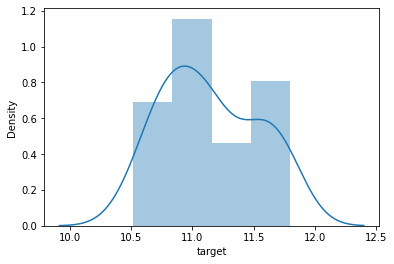

In [11]:
import seaborn as sns
import numpy as np
sns.distplot(data['target'].apply(lambda x: np.log1p(x)))

In [4]:
# class를 이용해서 모든 모델을 돌려준다.
final_rmse, model_score = final_model.run(data = data)

[07:19:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1412369988.5556505, tolerance: 1312106.386695238
  positive)


Learning rate set to 0.055526
0:	learn: 24454.5750321	total: 8.04ms	remaining: 8.04s
1:	learn: 23980.0745223	total: 15.6ms	remaining: 7.78s
2:	learn: 23471.4814108	total: 22.8ms	remaining: 7.58s
3:	learn: 22945.2464296	total: 30.8ms	remaining: 7.66s
4:	learn: 22434.9246107	total: 37.3ms	remaining: 7.42s
5:	learn: 21887.1478531	total: 44.8ms	remaining: 7.43s
6:	learn: 21499.7263327	total: 52.6ms	remaining: 7.46s
7:	learn: 21050.6775731	total: 60.5ms	remaining: 7.51s
8:	learn: 20675.6806395	total: 68.5ms	remaining: 7.55s
9:	learn: 20134.3177306	total: 76.8ms	remaining: 7.6s
10:	learn: 19724.5550617	total: 84.6ms	remaining: 7.6s
11:	learn: 19377.0295822	total: 92.7ms	remaining: 7.63s
12:	learn: 18880.9065158	total: 101ms	remaining: 7.63s
13:	learn: 18547.3822463	total: 108ms	remaining: 7.64s
14:	learn: 18215.5010074	total: 117ms	remaining: 7.65s
15:	learn: 17857.8254742	total: 124ms	remaining: 7.66s
16:	learn: 17428.8418652	total: 133ms	remaining: 7.67s
17:	learn: 17064.1524339	total: 141

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Learning rate set to 0.054478
0:	learn: 19169.6703303	total: 8.74ms	remaining: 8.73s
1:	learn: 18737.8415589	total: 15.7ms	remaining: 7.85s
2:	learn: 18341.6495909	total: 23.1ms	remaining: 7.69s
3:	learn: 17953.8068864	total: 30.6ms	remaining: 7.62s
4:	learn: 17565.1665683	total: 40.1ms	remaining: 7.98s
5:	learn: 17264.5655938	total: 47.4ms	remaining: 7.86s
6:	learn: 16978.7066645	total: 54.9ms	remaining: 7.78s
7:	learn: 16569.4956902	total: 62.3ms	remaining: 7.73s
8:	learn: 16213.7499320	total: 69.5ms	remaining: 7.66s
9:	learn: 15946.4985498	total: 76.7ms	remaining: 7.59s
10:	learn: 15582.7890407	total: 84.3ms	remaining: 7.58s
11:	learn: 15223.4976270	total: 91.6ms	remaining: 7.54s
12:	learn: 14878.6543170	total: 99.2ms	remaining: 7.53s
13:	learn: 14660.5133412	total: 107ms	remaining: 7.52s
14:	learn: 14362.0681360	total: 120ms	remaining: 7.87s
15:	learn: 14131.4087459	total: 133ms	remaining: 8.16s
16:	learn: 13870.9810138	total: 139ms	remaining: 8.05s
17:	learn: 13671.5094788	total: 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5070294.45975381, tolerance: 539336.3433214284
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10020691.937113943, tolerance: 810630.1235214287
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11631078.853671055, tolerance: 1251055.5243714286
  positive)


[07:21:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1412369988.5556505, tolerance: 1312106.386695238
  positive)


Learning rate set to 0.055526
0:	learn: 24454.5750321	total: 7.85ms	remaining: 7.85s
1:	learn: 23980.0745223	total: 15.8ms	remaining: 7.86s
2:	learn: 23471.4814108	total: 23.7ms	remaining: 7.89s
3:	learn: 22945.2464296	total: 31.6ms	remaining: 7.87s
4:	learn: 22434.9246107	total: 38ms	remaining: 7.55s
5:	learn: 21887.1478531	total: 45.3ms	remaining: 7.5s
6:	learn: 21499.7263327	total: 62.2ms	remaining: 8.82s
7:	learn: 21050.6775731	total: 78ms	remaining: 9.67s
8:	learn: 20675.6806395	total: 87.1ms	remaining: 9.59s
9:	learn: 20134.3177306	total: 94.9ms	remaining: 9.39s
10:	learn: 19724.5550617	total: 103ms	remaining: 9.24s
11:	learn: 19377.0295822	total: 112ms	remaining: 9.25s
12:	learn: 18880.9065158	total: 121ms	remaining: 9.16s
13:	learn: 18547.3822463	total: 146ms	remaining: 10.3s
14:	learn: 18215.5010074	total: 154ms	remaining: 10.1s
15:	learn: 17857.8254742	total: 163ms	remaining: 10s
16:	learn: 17428.8418652	total: 173ms	remaining: 10s
17:	learn: 17064.1524339	total: 184ms	remain

In [5]:
print(final_rmse, model_score)

{'lr': 67936.9404308032, 'lgb': 43249.31219833734, 'xgb': 46645.98934466342, 'lasso': 64917.50942882645, 'ridge': 66609.59382540888, 'cat': 42835.90585355409, 'ada': 41370.68654416333, 'rfg': 39415.24570836898, 'stack': 43896.61500028933, 'voting': 49397.928250825935} {'lr': -6.379015369879954, 'lgb': -1.990507229549183, 'xgb': -2.47868467336806, 'lasso': -5.7376763533522706, 'ridge': -6.0934909188941155, 'cat': -1.93360986274218, 'ada': -1.736351614202678, 'rfg': -1.4837902773617513, 'stack': -2.080693624730463, 'voting': -2.901251208998854}


In [11]:
print(len(y_train),len(X_train))

21 21


In [6]:
import statsmodels.api as sm

train = data[data['date'] <= 201712]
test = data[data['date'] > 201712]




X_train, y_train = train.drop('target', axis = 1), train['target']
X_test, y_test = test.drop('target', axis = 1), test['target']


model = sm.OLS(y_train, X_train)
result = model.fit()
result.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 target   R-squared (uncentered):                   0.966
Model:                            OLS   Adj. R-squared (uncentered):              0.880
Method:                 Least Squares   F-statistic:                              11.25
Date:                Wed, 14 Jul 2021   Prob (F-statistic):                     0.00345
Time:                        07:25:39   Log-Likelihood:                         -228.99
No. Observations:                  21   AIC:                                      488.0
Df Residuals:                       6   BIC:                                      503.6
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
date            -68.2889     40.643     -1.680      0.144    -167.738      31.160
month           719.5682   3666.496      0.196      0.851   -8252.024    9691.161
최고 기온(°C)      1.422e+04   3.24e+04      0.439      0.676    -6.5e+04    9.34e+04
최소 상대습도(%)    -6617.4920   6320.577     -1.047      0.335   -2.21e+04    8848.402
평균 기온(°C)     -3.691e+05   2.75e+05     -1.343      0.228   -1.04e+06    3.03e+05
평균 상대습도(%)     2853.4884   1.48e+04      0.192      0.854   -3.35e+04    3.92e+04
일강수량(mm)      -3647.6071   6297.784     -0.579      0.584   -1.91e+04    1.18e+04
평균 풍속(m/s)    -2.063e+05   1.05e+05     -1.965      0.097   -4.63e+05    5.06e+04
합계 일조 시간(hr)   -1.13e+04   3.67e+04     -0.307      0.769   -1.01e+05    7.86e+04
0.5m 지중온도(°C) -4344.1533   1.27e+04     -0.342      0.744   -3.54e+04    2.67e+04
최대 풍속(m/s)     3.885e+04    5.5e+04      0.707      0.506   -9.56e+04    1.73e+05
합계 일사량(MJ/m2)  1055.5215   1.81e+04      0.058      0.956   -4.33e+04    4.55e+04
여름철 체감온도       9544.2438   5850.730      1.631      0.154   -4771.978    2.39e+04
겨울철 체감온도       3.272e+05   2.58e+05      1.268      0.252   -3.04e+05    9.59e+05
불쾌지수           5.127e+04   1.22e+05      0.419      0.690   -2.48e+05     3.5e+05
==============================================================================
Omnibus:                        1.640   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.440   Jarque-Bera (JB):                0.808
Skew:                          -0.478   Prob(JB):                        0.668
Kurtosis:                       3.093   Cond. No.                     1.39e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
class season_month():
  def __init__(self, data=None, month_col=None):
    self.df = data
    self.col = month_col
    self.Season = ["Spring", "Summer", "Fall", "Winter"]
    self.Spring = []
    self.Summer = []
    self.Fall = []
    self.Winter = []
  def rename_col(self): #weather index 사용하기 위해 칼럼명 동일하게 바꿈
    df_col = [col for col in self.df.columns]
    df_ncol = [col.split('(')[0].replace(' ', '') for col in df_col]
    col_dict = {}
    for c, n in zip(df_col, df_ncol):
      if c==n:
        pass
      else:
        col_dict[c]=n
    self.df.rename(columns=col_dict, inplace=True)
  def split_monthDF(self):
    # month dtype : int
    # 계절 특성 반영한 지수 columns까지 포함한 데이터를 월별로 반환
    for month in range(1, 12):
      lmocals()[f'idx_{onth}'] = []
      for idx, chk in enumerate(self.df[self.col]):
        if month==chk:
          locals()[f'idx_{month}'].append(idx)
      locals()[f'M{month}'] = data.iloc[locals()[f'idx_{month}'], :]
    return M1, M2, M3, M4, M5, M6, M7, M8, M9, M10, M11, M12
  def merge_season(self):
    self.df = self.df.merge(self.Spring, how='left').merge(self.Summer, how='left')#left가 맞음???
    self.df = self.df.merge(self.Fall, how='left').merge(self.Winter, how='left')
    return self.df
  def seperate_season(self):
    # month dtype : int
    # 3·4·5월-봄, 6·7·8월-여름, 9·10·11월-가을, 12·1·2월-겨울
    for idx, chk in enumerate(self.df[self.col]):
      if (chk>=3) and (chk<=5):
        self.Spring.append(idx)
      elif (chk>=6) and (chk<=8):
        self.Summer.append(idx)
      elif (chk>=9) and (chk<=11):
        self.Fall.append(idx)
      elif (chk==12) or (chk==1) or (chk==2):
        self.Winter.append(idx)
    for ss in self.Season:
      globals()[f'DF_{ss}'] = self.df.iloc[eval(f'self.{ss}'), :]
      globals()[f'DF_{ss}']['Season'] = [f'{ss}' for reap in range(globals()[f'DF_{ss}'].shape[0])]
    return DF_Spring, DF_Summer, DF_Fall, DF_Winter
  def Season_weather_index(self):
    for ss in self.Season:
      globals()[f'self.{ss}']['불쾌지수'] = self.discomfort_index(ss)
      return globals()[f'self.{ss}']
      if ss=='Summer':
        globals()[f'self.{ss}']['체감온도'] = self.summer_feature(ss)
        return globals()[f'self.{ss}']
      elif ss=='Winter':
        globals()[f'self.{ss}']['체감온도'] = self.winter_feature(ss)
        return globals()[f'self.{ss}']
      else:
        pass
    return self.Spring, self.Summer, self.Fall, self.Winter
  # 여름철 체감온도
  def summer_feature(self, season=None):
    H = eval(f"self.{season}['평균상대습도']")
    T = eval(f"self.{season}['평균기온']").apply(lambda x:32 + (1.8 * x))
    self.SMSensibleTemperature = -42.379 + (2.04901523*T) + (10.14333127 * H) - (0.22475541 * T * H) - (6.83783 * (10 ** -3) * (T ** 2)) - (5.481717 * (10 ** -2)*(H**2)) + (1.22874 * (10 ** -3) * (T ** 2) * H) + (8.5282 * (10 ** -4) * T * (H **2)) - (1.99 * (10**-6) * (T**2) * (H**2))
    # self.Summer['체감온도'] = SensibleTemperature
    return self.SMSensibleTemperature
  # 겨울철 체감온도
  def winter_feature(self, season=None):
    T = eval(f"self.{season}['평균기온']").apply(lambda x:32 + (1.8*x))
    V = eval(f"self.{season}['평균풍속']")
    self.WTSensibleTemperature = 13.12 + (0.6215 * T) - (11.37 * 0.16 ** V) + (0.3965 *V *0.16**T)
    # self.df['체감온도'] = SensibleTemperature
    return self.WTSensibleTemperature
  # 불쾌지수 구하기
  def discomfort_index(self, season=None):
    T = eval(f"self.{season}['평균기온']")
    H = eval(f"self.{season}['평균상대습도']")
    self.discomfort_index = (9/5 * T) - (0.55 * (1 - H/100) * ((9/5 * T) - 26)) + 32
    # self.df['불쾌지수'] = self.discomfort_index
    return self.discomfort_index
  def season_map(self):#merge된 데이터프레임 사용해야 함
    self.df['Season'] = self.df['Season'].map({'Spring':1, 'Summer':2, 'Fall':3, 'Winter':4})
    return self.df

In [ ]:
season_month(data = data, )